# 分位点回帰とエクスペクタイル回帰

## 分位点回帰 (Quantile Regression)
線形回帰(linear regression)は，誤差が正規分布と仮定したとき(必ずしも正規分布を仮定しなくてもよい)の$X$(説明変数)に対する$Y$(目的変数)の期待値$E[Y]$を求める，というものであった．**分位点回帰(quantile regression)** では，Xに対するYの分布における分位点を通るような直線を引く．

**分位点**(または分位数)において，代表的なものが**四分位数**である．四分位数は箱ひげ図などで用いるが，例えば第一四分位数は分布を25:75に分ける数，第二四分位数(中央値)は分布を50:50に分ける数である．同様に$q$分位数($q$-quantile)というと分布を$q:1-q$に分ける数となっている．分位点回帰の話に戻る．下図は$x\sim U(0, 5),\quad y=3x+x\cdot \xi,\quad \xi\sim N(0,1)$とした500個の点に対する分位点回帰である．赤い領域はX=1,2,3,4でのYの分布を示している．深緑，緑，黄色の直線はそれぞれ10, 50, 90%tile回帰の結果である．例えば50%tile回帰の結果は，Xが与えられたときのYの中央値(50%tile点)を通るような直線となっている．同様に90%tile回帰の結果は90%tile点を通るような直線となっている．

In [1]:
using PyPlot, LinearAlgebra, Random

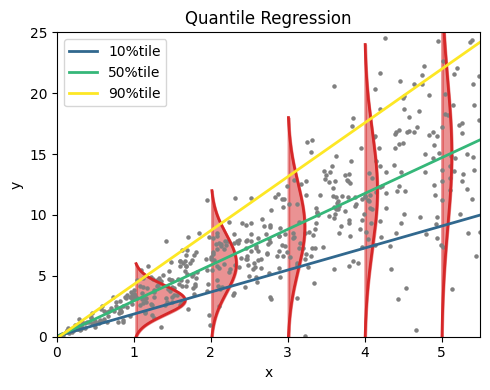

In [2]:
function QuantileGradientDescent(X, y, initθ, τ; lr=1e-4, num_iters=10000)
    θ = initθ
    for i in 1:num_iters
        ŷ = X * θ # predictions
        δ = y - ŷ  # error
        grad = abs.(τ .- 1.0(δ .<= 0.)) .* sign.(δ) # gradient
        θ += lr * X' * grad # Update
    end
    return θ
end;

function gaussian_func(x, μ, σ)
    return 0.8/σ*exp(-(x -μ)^2/(2σ^2))
end;

# Generate Toy datas
N = 500 # sample size
x = sort(5.5rand(N))
y = 3x + x .* randn(N);
X = ones(N, 2) # design matrix
X[:, 2] = x;
τs = [0.1, 0.5, 0.9]
m = length(τs) 
Ŷ = zeros(m, N); # memory array
for i in 1:m
    initθ = zeros(2) # init variables
    θ = QuantileGradientDescent(X, y, initθ, τs[i])
    Ŷ[i, :] = X * θ
end

# Results plot
figure(figsize=(5,4))
title("Quantile Regression")
for loc in 1:5
    ξy = 0:1e-3:6loc
    ξx = loc .+ gaussian_func.(ξy, 3loc, 1.2loc)
    fill_between(ξx, -1, ξy, color="tab:red", linewidth=2, alpha=0.5)
    plot(ξx, ξy, color="tab:red", linewidth=2)
end
cmvir = get_cmap(:viridis)
for i in 1:m
    plot(x, Ŷ[i, :], linewidth=2, label=string(Int(τs[i]*100))*"%tile", color=cmvir(i/m)) # regression line
end
scatter(x, y, color="gray", s=5) # samples
xlabel("x"); ylabel("y")
xlim(0, 5.5); ylim(0, 25); legend()
tight_layout()

分位点回帰の利点としては，外れ値に対して堅牢(ロバスト)である，Yの分布が非対称である場合にも適応できる，などがある ([Das et al., *Nat Methods*. 2019](https://www.nature.com/articles/s41592-019-0406-y))．

## エクスペクタイル回帰 (Expectile regression)
エクスペクタイル(expectile)は([Newey and Powell 1987](https://www.jstor.org/stable/1911031?seq=1)) によって導入された統計汎関数 (statistical functional; SF)の一種であり，期待値(expectation)と分位数(quantile)を合わせた概念である．簡単に言えば，中央値(median)の一般化が分位数(quantile)であるのと同様に，期待値(expectation)の一般化がエクスペクタイル(expectile)である．

## 勾配法を用いた分位点回帰・エクスペクタイル回帰
予測誤差$\delta$と$\tau$の関数を

$$
\begin{align}
\text{分位点回帰：}&\quad
\rho_q(\delta; \tau)=\left|\tau-\mathbb{I}_{\delta \leq 0}\right|\cdot |\delta|=\left(\tau-\mathbb{I}_{\delta \leq 0}\right)\cdot \delta\\
\text{エクスペクタイル回帰：}&\quad
\rho_e(\delta; \tau)=\left|\tau-\mathbb{I}_{\delta \leq 0}\right|\cdot \delta^2
\end{align}
$$

と定義する．$\rho_q(\delta; \tau)$のみ，チェック関数 (check function)あるいは非対称絶対損失関数(asymmetric absolute loss function)と呼ぶ．ただし，$\tau$は分位点(quantile)，$\mathbb{I}$は指示関数(indicator function)である．この場合，$\mathbb{I}_{\delta \leq 0}$は$\delta \gt 0$なら0, $\delta \leq 0$なら1となる．このとき，目的関数は 

$$
L_{\tau}(\delta)
=\sum_{i=1}^n \rho(\delta_i; \tau)
$$

である．$\rho(\delta; \tau)$を色々な $\tau$についてplotすると次図のようになる．

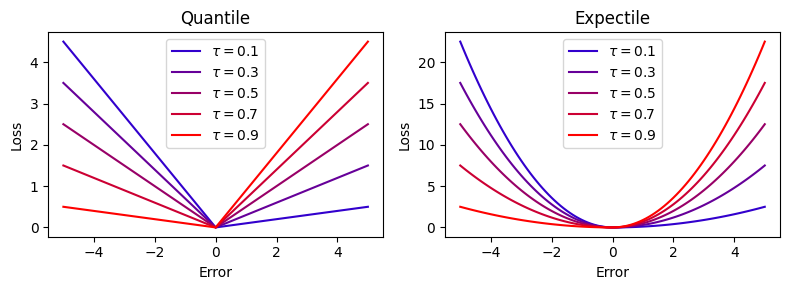

In [3]:
δ = -5:0.1:5
τ= 0.1:0.2:0.9
cmbrg = get_cmap(:brg) 
figure(figsize=(8,3))
subplot(1,2,1)
title("Quantile")
for i in 1:length(τ)
    indic = 1.0(δ .<= 0)
    z = (τ[i] .- indic) .* δ
    plot(δ, z, color=cmbrg(0.5i/length(τ)), label=L"$\tau=$"*string(τ[i]))
end
xlabel("Error"); ylabel("Loss")
legend(); tight_layout()

subplot(1,2,2)
title("Expectile")
for i in 1:length(τ)
    indic = 1.0(δ .<= 0)
    z = abs.(τ[i] .- indic) .* δ.^2
    plot(δ, z, color=cmbrg(0.5i/length(τ)), label=L"$\tau=$"*string(τ[i]))
end
xlabel("Error"); ylabel("Loss")
legend(); tight_layout()

分位点の場合，$\rho_q(\delta; \tau)$がチェックマーク✓に類似していることからこのような名前が付いている．

$L_\tau$を最小化するような$\theta$の更新式について考える．まず，


$$
\begin{align}
\text{分位点回帰：}&\quad
\frac{\partial \rho_q(\delta; \tau)}{\partial \delta}= \rho_q^{\prime}(\delta; \tau)=\left|\tau-\mathbb{I}_{\delta \leq 0}\right| \cdot
\operatorname{sign}(\delta)\\
\text{エクスペクタイル回帰：}&\quad
\frac{\partial \rho_e(\delta; \tau)}{\partial \delta}= \rho_e^{\prime}(\delta; \tau)=2\left|\tau-\mathbb{I}_{\delta \leq 0}\right| \cdot
\delta
\end{align}
$$

である (ただし$\text{sign}(\cdot)$は符号関数)．さらに

$$
\frac{\partial L_{\tau}}{\partial \theta}=\frac{\partial L_{\tau}}{\partial \delta}\frac{\partial \delta(\theta)}{\partial \theta}=-\frac{1}{n} \rho^{\prime}(\delta; \tau) X
$$ 

が成り立つので，$\theta$の更新式は$\theta \leftarrow \theta + \alpha\cdot \dfrac{1}{n} \rho^{\prime}(\delta; \tau) X$と書ける ($\alpha$は学習率である)．分位点回帰を単純な勾配法で求める場合，勾配が0となって解が求まらない可能性があるが，目的関数を滑らかにすることで回避できるという研究もある ([Zheng. *IJMLC*. 2011](https://link.springer.com/article/10.1007/s13042-011-0031-2))．この点，Expectileならこの問題を回避できる (?)．


In [4]:
function QuantileGradientDescent(X, y, initθ, τ; lr=1e-4, num_iters=10000)
    θ = initθ
    for i in 1:num_iters
        ŷ = X * θ # predictions
        δ = y - ŷ  # error
        grad = abs.(τ .- 1.0(δ .<= 0.)) .* sign.(δ) # gradient
        θ += lr * X' * grad # Update
    end
    return θ
end

function ExpectileGradientDescent(X, y, initθ, τ; lr=1e-4, num_iters=10000)
    θ = initθ
    for i in 1:num_iters
        ŷ = X * θ # predictions
        δ = y - ŷ  # error
        grad = 2*abs.(τ .- 1.0(δ .<= 0.)) .* δ # gradient
        θ += lr * X' * grad # Update
    end
    return θ
end;

In [5]:
# Generate Toy datas
N = 500 # sample size
dims = 3 # dimensions
x = sort(randn(N))
y =  x.^2 + 3x + 5x .* randn(N);
X = [ones(N) x x.^2]; # design matrix

In [6]:
τs = [0.01, 0.1, 0.5, 0.9, 0.99]
m = length(τs) 
initθ = zeros(dims)

# Quantile regression
Ŷq = zeros(m, N); # memory array
for i in 1:m
    θq = QuantileGradientDescent(X, y, initθ, τs[i])
    Ŷq[i, :] = X * θq
end

# Expectile regression
Ŷe = zeros(m, N); # memory array
for i in 1:m
    θe = ExpectileGradientDescent(X, y, initθ, τs[i])
    Ŷe[i, :] = X * θe
end

In [7]:
# normal equation
θ = (X' * X) \ X' * y
ŷ = X * θ; # predictions

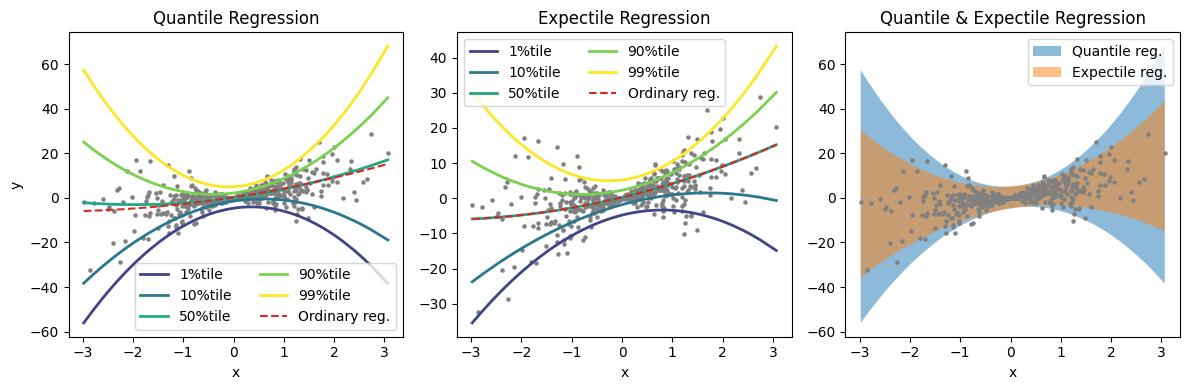

In [8]:
# Results plot
figure(figsize=(12,4), dpi=100)
subplot(1,3,1)
title("Quantile Regression")
cm = get_cmap(:viridis)
for i in 1:m
    plot(x, Ŷq[i, :], linewidth=2, label=string(Int(τs[i]*100))*"%tile", color=cm(i/m)) # regression line
end
plot(x, ŷ, color="tab:red",  "--", label="Ordinary reg.")  # regression line
scatter(x, y, color="gray", s=5) # samples
xlabel("x"); ylabel("y"); legend(ncol=2)

# Results plot
subplot(1,3,2)
title("Expectile Regression")
cm = get_cmap(:viridis)
for i in 1:m
    plot(x, Ŷe[i, :], linewidth=2, label=string(Int(τs[i]*100))*"%tile", color=cm(i/m)) # regression line
end
plot(x, ŷ, color="tab:red", "--", label="Ordinary reg.")  # regression line
scatter(x, y, color="gray", s=5) # samples
xlabel("x"); legend(ncol=2)

subplot(1,3,3)
title("Quantile & Expectile Regression")
fill_between(x, Ŷq[1, :], Ŷq[end, :], alpha=0.5, label="Quantile reg.")
fill_between(x, Ŷe[1, :], Ŷe[end, :], alpha=0.5, label="Expectile reg.")
scatter(x, y, color="gray", s=5) # samples
xlabel("x"); legend()
tight_layout()

## 参考文献
- https://en.wikipedia.org/wiki/Quantile_regression
- Das, K., Krzywinski, M. & Altman, N. Quantile regression. Nat Methods 16, 451–452 (2019) doi:[10.1038/s41592-019-0406-y](https://www.nature.com/articles/s41592-019-0406-y)
- Quantile and Expectile Regressions ([pdf](https://freakonometrics.hypotheses.org/files/2017/05/erasmus-1.pdf))